# CNN con Pytorch

Repetimos el ejemplo de Keras pero ahora utilizando Pytorch. Como veremos es mucho mas complejo ya que nos permite definir mas en detalle todo el proceso.

In [1]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Definimos la arquitectura de la CNN

Definimos como el modelo debe cargar los datos

In [28]:
class MyDataset(Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]
        label = F.one_hot(torch.tensor(self.dataset[idx]["label"]), num_classes=20).float()

        image = self.transforms(image)
        return image, label

Definimos el proceso de entrenamiento paso a paso

In [38]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

Definimos el proceso de validacion paso a paso

In [4]:
def validation(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            target = target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target).sum().item()

    val_loss /= len(val_loader.dataset)
    print(f'\nTest set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n')

Cargamos los datos igual que hicimos antes

In [5]:
!pip install datasets --upgrade --quiet

In [6]:
from datasets import load_dataset
ds = load_dataset('Matthijs/snacks', split='train')
ds = ds.train_test_split(test_size=0.2, shuffle=True, stratify_by_column='label')
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3870
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 968
    })
})

In [7]:
fila_ejemplo = ds['train'][0]
fila_ejemplo

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=341x256>,
 'label': 7}

(256, 341, 3)


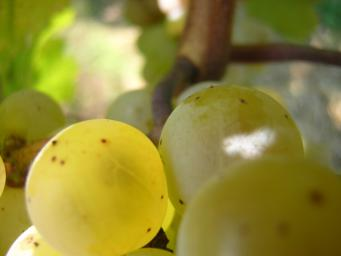

In [20]:
print(np.array(fila_ejemplo['image']).shape)
fila_ejemplo['image']

In [9]:
fila_ejemplo['label']

7

In [10]:
labels = ds['train'].features['label']
len(labels.names), labels.names

(20,
 ['apple',
  'banana',
  'cake',
  'candy',
  'carrot',
  'cookie',
  'doughnut',
  'grape',
  'hot dog',
  'ice cream',
  'juice',
  'muffin',
  'orange',
  'pineapple',
  'popcorn',
  'pretzel',
  'salad',
  'strawberry',
  'waffle',
  'watermelon'])

In [11]:
len(ds['train'])

3870

In [32]:
my_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [33]:
train_dataset = MyDataset(ds['train'], my_transforms)
val_dataset = MyDataset(ds['test'], my_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

In [34]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

In [35]:
train_dataset[0][1]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [ ]:
import torchvision.models as models
model = models.mobilenet_v2() # entrena desde cero
#model = models.mobilenet_v2(pretrained=True) # hace finetuning
model.classifier[1] = nn.Linear(model.last_channel, 20)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(1, 10):
    train(model, device, train_loader, criterion, optimizer, epoch)
    validation(model, device, val_loader, criterion)

#torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/3870 (0%)]	Loss: 3.007408
Train Epoch: 1 [640/3870 (16%)]	Loss: 3.094942
Train Epoch: 1 [1280/3870 (33%)]	Loss: 2.956803
Train Epoch: 1 [1920/3870 (49%)]	Loss: 3.151371
Train Epoch: 1 [2560/3870 (66%)]	Loss: 3.131435
Train Epoch: 1 [3200/3870 (82%)]	Loss: 2.791562
Train Epoch: 1 [1800/3870 (98%)]	Loss: 2.839544

Test set: Average loss: 0.0550, Accuracy: 53/968 (5%)

Train Epoch: 2 [0/3870 (0%)]	Loss: 2.989757
Train Epoch: 2 [640/3870 (16%)]	Loss: 2.659425
Train Epoch: 2 [1280/3870 (33%)]	Loss: 2.845228
Train Epoch: 2 [1920/3870 (49%)]	Loss: 2.944454
Train Epoch: 2 [2560/3870 (66%)]	Loss: 2.965549
Train Epoch: 2 [3200/3870 (82%)]	Loss: 2.584206
Train Epoch: 2 [1800/3870 (98%)]	Loss: 2.726939

Test set: Average loss: 0.0491, Accuracy: 146/968 (15%)

Train Epoch: 3 [0/3870 (0%)]	Loss: 2.717292
Train Epoch: 3 [640/3870 (16%)]	Loss: 2.612988
Train Epoch: 3 [1280/3870 (33%)]	Loss: 2.640165
Train Epoch: 3 [1920/3870 (49%)]	Loss: 2.882713
Train Epoch: 3 [2560/3870 (66%)]	Loss

## Predecir una imagen nueva

In [ ]:
import requests
from io import BytesIO

def predict_image(model, image_path):
  model.eval()  # Uso el modelo en modo evaluacion
  transform = transforms.Compose([
      transforms.Resize((256, 256)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  if image_path.startswith("http"):
    response = requests.get(image_path)
    image = Image.open(BytesIO(response.content))
  else:
    image = Image.open(image_path)
  image = transform(image).unsqueeze(0).to(device)  # Adapto la imagen para pasarla a la red

  with torch.no_grad():
    output = model(image)
    predicted_class = output.argmax(dim=1).item()

  return predicted_class

# path de la imagen a predecir
image_path = 'https://www.collinsdictionary.com/images/full/grape_229112122.jpg'  
predicted_class = predict_image(model, image_path)
print(f"The predicted class for the image is: {predicted_class}")


## Como guardar el modelo entrenado en hugging face

In [ ]:
from huggingface_hub import HfApi
from huggingface_hub import notebook_login

notebook_login()

# cambiar el nombre de usuario
nombre_del_modelo = "amiune/snack-classifier-pytorch"

api = HfApi()
api.create_repo(repo_id=nombre_del_modelo, exist_ok=True)


model_path = "snack-classifier"
os.makedirs(model_path, exist_ok=True)
torch.save(model.state_dict(), os.path.join(model_path, "pytorch_model.bin"))

api.upload_folder(
    folder_path=model_path,
    path_in_repo="",
    repo_id=nombre_del_modelo,
)


# Fin: [Volver al contenido del curso](https://www.freecodingtour.com/cursos/espanol/deeplearning/deeplearning.html)

## Referencias:

- https://github.com/pytorch/examples/blob/main/mnist/main.py
- https://www.kaggle.com/datasets/oddrationale/mnist-in-csv